[Inhalt](./Einleitung.ipynb)

# PointNet-Klassifizierungsnetzwerk

Im Rahmen dieses Notebooks wird anhand einer beispielhaften Implementation die praktische Anwendung der PointNet-Architektur zur Klassifizierung dreidimensionaler Objekte in Form von Punktwolken gezeigt. Der verwendete Code entstammt einer Implementation von G. Li, zu finden im folgenden Git-Repository: https://github.com/garyli1019/pointnet-keras.

Die folgende Grafik von Qi et al. \[1\] zeigt die Architektur von PointNet. Der markierte Bereich stellt hierbei das Klassifikationsnetzwerk dar. Diese Darstellung wird im weiteren Verlauf des Notebooks wiederholt genutzt, um das Durchlaufen der Pipeline zu visualisieren.

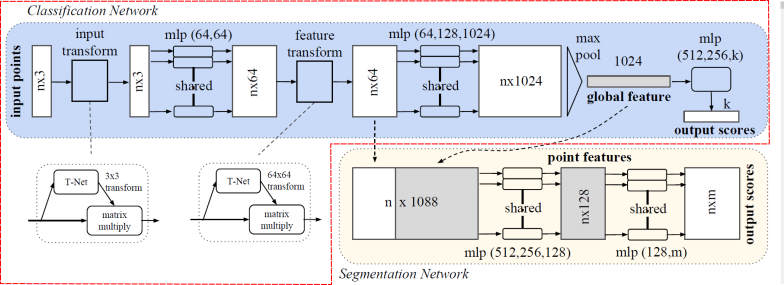
<center>Abbildung 1: PointNet-Klassifizierungsnetzwerk [1] </center>



## Anwendungshinweis

Da es sich bei dem Code in diesem Notebook um ein zusammenhängendes Script handelt, empfiehlt sich bei Änderungen stets das Zurücksetzen des Kernels. Hierfür wird unter dem Reiter "Kernel" die Option "Restart & Run all" ausgewählt.

## Imports

Für die hier analyiserte Keras-Implementation der PointNet-Architektur werden drei Pakete benötigt:
* NumPy für die Verwaltung von Datenstrukturen sowie der Handhabung von Vektoren und Matrizen
* H5Py als Schnittstelle für das HDF5-Datenformat
* Tensorflow für die Verwendung der Keras-API, welche Teil des Tensorflow-Cores ist

Darüber hinaus werden die nötigen Keras-Pakete für die Schichttypen und die Erzeugung des Modells importiert.


In [1]:
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
import os
import tensorflow as tf
from keras import optimizers
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Flatten, Reshape, Dropout
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from keras.layers import Lambda
from keras.utils import np_utils
import h5py

Using TensorFlow backend.


## Hilfsfunktionen

Nachfolgend werden Hilfsfunktionen definiert. Die Funktion mat_mul wird benötigt, um die Matritzenmultiplikation innerhalb einer Keras-Schicht anwenden zu können. Load_h5 dient dem Laden einer HPF5-Datei und gibt deren Inhalt und Labels zurück.

In [2]:
def mat_mul(A, B):
    return tf.matmul(A, B)

In [3]:
def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)

Die Funktionen rotate_point_cloud sowie jitter_point_cloud dienen dazu, die Trainingsdaten wiederholt nutzbar zu machen. Durch zufällige Rotationen und Mikro-Translationen der Objekte bzw. Punkte erzeugen die Funktionen aus einem Datensatz eine beliebige Menge unterschiedlicher Trainingsdaten.

rotate_point_cloud erzeugt zunächst eine Nullmatrix mit den Dimensionen des Inputs. Anschließend wird für jedes Objekt eine zufällige Rotationsmatrix erzeugt. Die Produkte der Rotationsmatrix und der Objektpunkte werden in die Nullmatrix eingefügt, welche nach Durchlaufen aller Objekte zurückgegeben wird. Die Rotationsachse ist die Y-Achse.

jitter_point_cloud erzeugt ebenfalls eine Kopie des Inputs. Diese wird jedoch nicht als Nullmatrix initialisiert, sondern mit kleinen Zufallszahlen gefüllt. Anschließend erfolgt eine elementweise Addition mit der Input-Matrix.

In [4]:
def rotate_point_cloud(batch_data):
    """ Randomly rotate the point clouds to augument the dataset
        rotation is per shape based along up direction
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, rotated batch of point clouds
    """
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.matmul(shape_pc.reshape((-1, 3)), rotation_matrix)
    return rotated_data

In [5]:
def jitter_point_cloud(batch_data, sigma=0.01, clip=0.05):
    """ Randomly jitter points. jittering is per point.
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, jittered batch of point clouds
    """
    B, N, C = batch_data.shape
    assert(clip > 0)
    jittered_data = np.clip(sigma * np.random.randn(B, N, C), -1 * clip, clip)
    jittered_data += batch_data
    return jittered_data

Die folgenden globalen Variablen bestimmen wichtige Randbedingungen der verwendeten Datensätze sowie den verwendenten Optimierungsalgorithmus und sollten daher nicht verändert werden.


In [6]:
# number of points in each sample
num_points = 2048

# number of categories
k = 40

# define optimizer
adam = optimizers.Adam(lr=0.001, decay=0.7)

## PointNet als Keras-Modell

In der Deep-Learning-API Keras werden künstliche neuronale Netze in Form von Modellen implementiert. Beginnend mit der Definition eines Inputs werden werden Schichten und Funktionen aneinandergereiht. Abgeschlossen wird das Modell durch die Angabe eines Outputs, welcher über die Schichten mit dem Input verbunden ist. 

Die Verknüfpung erfolgt bei vorwärtsgerichteten KNN durch die Angabe der vorherigen Schicht als Parameter. Ein Beispiel:
```
input = Input(shape=(data))
op1 = Schichtfunktion(Parameter)(input)
op2 = Schichtfunktion(Parameter)(op2)
...
output = Schichtfunktion(Parameter)(opx)
```

Im Folgenden wird das Modell für PointNet aufgebaut. Hierbei findet im ersten Schritt die in der Abbildung markierte Input-Transformation statt.  

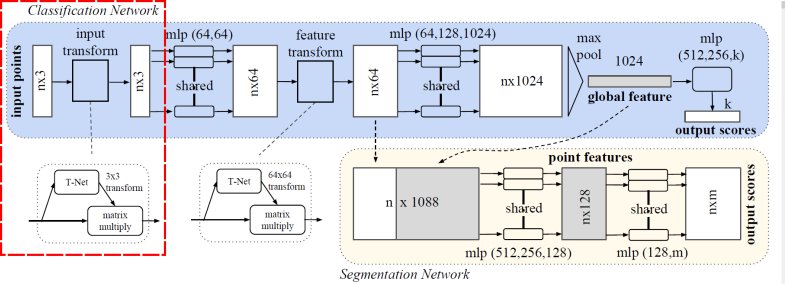
<center>Abbildung 2: Input-Transformation [1] </center>

Mithilfe eines eigenständigen Mini-Netzwerks bestimmt PointNet eine Transformationsmatrix, welche via Matritzenmultiplikation auf den Input angewendet wird. Hierdurch soll die räumliche Ausrichtung auf eine Basis-Pose durchgeführt werden. Der Aufbau des T-Net sieht wie folgt aus:

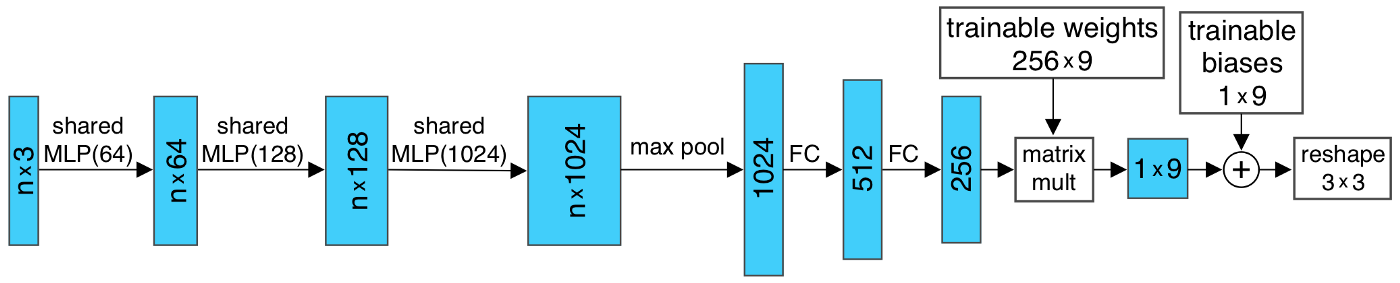
<center>Abbildung 3: Aufbau T-Net [3]</center>

Im nachfolgenden Code-Block wird wie zuvor beschrieben zunächst der Input definiert. Die MLP-Schichten werden als 1D-Faltungen mit 64, 128 bzw. 1024 Filtern sowie einer Kernelgröße von 1 realisiert. Als Aktivierungfunktion wird ReLU verwendet. 

Die Punkte werden demnach zwar mit geteilten Gewichten, aber dennoch individuell auf höherdimensionale Räume abgebildet. Nach jeder Schicht wird eine batch normalization durchgeführt, bei der die Output-Werte stapelweise von deren Durchschnitt subtrahiert und durch die Varianz geteilt werden. 


In [7]:
# ------------------------------------ Pointnet Architecture
# input_Transformation_net
input_points = Input(shape=(num_points, 3))
x = Convolution1D(64, 1, activation='relu',
                  input_shape=(num_points, 3))(input_points)
x = BatchNormalization()(x)
x = Convolution1D(128, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = Convolution1D(1024, 1, activation='relu')(x)
x = BatchNormalization()(x)

Im Anschluss an die letzte Faultung werden die Features mittels Max-Pooling aggregiert und über mehrere FC-Layer zunächst auf 256 Werte reduziert. Diese sind in Form mehrerer Dense Layer implementiert. 

Die letzte Dense Layer bestimmt hieraus mit 256x9 Gewichten die 9 Elemente der Transformationsmatrix `input_T`. Der Output wird als Einheitsmatrix initialisiert und im finalen Schrit in die gewünschte 3x3-Form gebracht.

Auch hier wird mit Ausnahme des letzten Schrittes nach jeder Schicht eine batch normalization durchgeführt.

In [8]:
x = MaxPooling1D(pool_size=num_points)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(9, weights=[np.zeros([256, 9]), np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)])(x)
input_T = Reshape((3, 3))(x)

Nachdem die Transformationsmatrix bestimmt wurde, kann diese über eine Lambda-Schicht mit dem Input multipliziert werden. Lambda-Schichten ermöglichen es, beliebige Funktionen in das Modell eines neuronalen Netzwerks einzubauen.

Das Feature-Building wird gemäß der Architekturvorgaben - markiert in der nachfolgenden Abbildung - mittels zwei 1D-Faltungen mit 64 Filtern, einer Kernelgröße von 1 und der Aktivierungsfunktion ReLU durchgeführt.


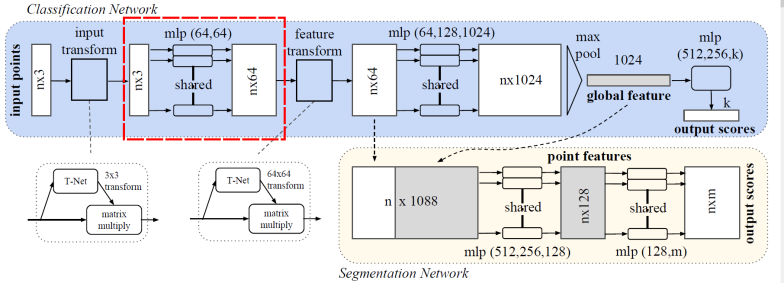
<center>Abbildung 4: Feature Building 1 [1] </center>

In [9]:
# forward net
g = Lambda(mat_mul, arguments={'B': input_T})(input_points)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)

Der dritte Schritt im PointNet-Klassifizierungsnetzwerk ist die in der folgenden Abbildung markierte Feature-Transformation.

Wie im ersten Schritt wird über ein unabhängiges T-Net eine Transformationsmatrix bestimmt und mit dem aktuellen Input multipliziert. Im Aufbau unterscheidet sich das T-Net zur Feature-Transformation nur in den Werten der Parameter einzelner Schichten. So besitzt die Transformationsmatrix bspw. eine Größe von 64x64 Werten.

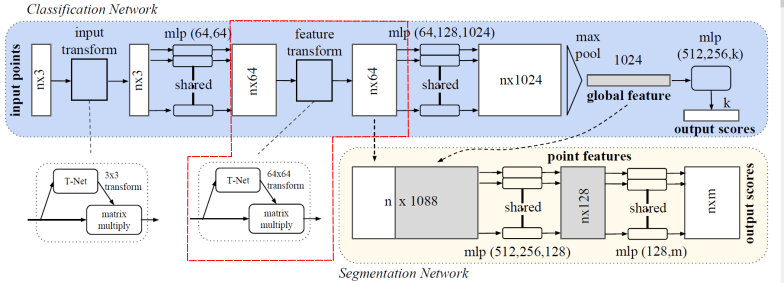
<center>Abbildung 5: Feature-Transformation [1] </center>

In [10]:
# feature transform net
f = Convolution1D(64, 1, activation='relu')(g)
f = BatchNormalization()(f)
f = Convolution1D(128, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = Convolution1D(1024, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = MaxPooling1D(pool_size=num_points)(f)
f = Dense(512, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(256, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
feature_T = Reshape((64, 64))(f)

Mit der Feature-Transformationsmatrix kann nun durch eine Matritzenmultiplikation der Input für die zweite Iteration des Feature Building angepasst werden. Auch hier ist das Ziel eine Ausrichtung der Daten zur Erzeugung einer einheitlichen Form, welche invariant gegenüber Transformationen des ursprünglichen Inputs ist.

Der transformierte Input wird mittels dreier 1D-Faltungsoperationen von 64 zunächst auf 128 und schließlich auf 1024 Werte abgebildet. Wie in den vorangegangenen Schritten werden hierfür Kernel der Größe 1 und ReLU als Aktivierungsfunktion genutzt. Zwischen den Schichten erfolgt batch normalization.

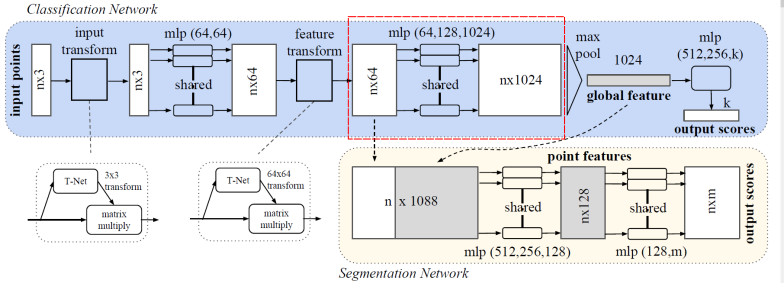
<center>Abbildung 6: Feature Building 2 [1] </center>

In [11]:
# forward net
g = Lambda(mat_mul, arguments={'B': feature_T})(g)
g = Convolution1D(64, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(128, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(1024, 1, activation='relu')(g)
g = BatchNormalization()(g)

Für den vorletzten Schritt des Klassifizierungsnetzwerks ist lediglich eine einzelne Zeile vonnöten. 

Mithilfe der MaxPooling1D-Funktion wird aus den Features eine globale Signatur erzeugt. 
Die Größe des Pools entspricht hierbei der Anzahl der Punkte n. Dies führt dazu, dass für jeden der 1024 Feature-Werte das Maximum aus allen Punkten herausgefiltert wird.

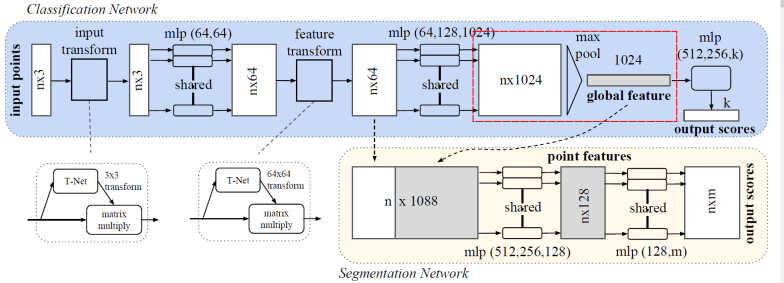
<center>Abbildung 7: Max-Pooling [1] </center>

In [12]:
# global_feature
global_feature = MaxPooling1D(pool_size=num_points)(g)

Mit dem globalen Feature-Vektor kann nun die eigentliche Klassifizierung erfolgen. Alle vorangegangenen Schritte dienten dazu, den Input in eine klassifizierbare Form zu bringen, welche invariant gegenüber Permuationen und Transformationen ist.

Für die Klassifzierung werden zwei Dense Layer mit ReLU genutzt, um die globalen Features auf 256 Werte reduzieren. Nach jedem Schritt findet eine batch normalization. Darüber hinaus werden pro Dense Layer 30% der Punkte zufällig via Dropout entfernt.

Die dritte Dense Layer nutzt die Softmax-Aktivierungsfunktion und reduziert den Feature-Vektor auf einen k-dimensionalen Vektor, wobei k die Anzahl der Kategorien ist. Das Ergebnis wird als `prediction` gespeichert.


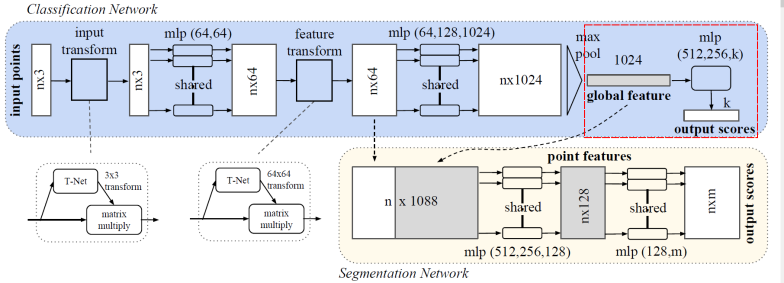
<center>Abbildung 8: Klassifizierung [1] </center>

In [13]:
# point_net_cls
#TODO: Dropout auf 0.3
c = Dense(512, activation='relu')(global_feature)
c = BatchNormalization()(c)
c = Dropout(rate=0.3)(c)
c = Dense(256, activation='relu')(c)
c = BatchNormalization()(c)
c = Dropout(rate=0.3)(c)
c = Dense(k, activation='softmax')(c)
prediction = Flatten()(c)
# --------------------------------------------------end of pointnet

Nachdem Input und Output definiert und über mehrere Schichten miteinander verknüpft wurden, kann das Modell definiert werden.

Die folgende Code-Zelle gibt eine Zusammenfassung über die Schichten und die Anzahl der Parameter im Netzwerk aus. 

Da es sich bei diesem Jupyter Notebook um ein interaktives Werk handelt, sei der Leser herzlich eingeladen, die Parameter der Schichten zu editieren und deren Auswirkungen auf die Größe des Netzwerks und den Trainingsprozess zu beobachten. Hierfür eignen sich vor neben den Größenparametern der Schichten auch die Aktivierungsfunktionen und die Dropout-Rate.

In [14]:
# print the model summary
model = Model(inputs=input_points, outputs=prediction)
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2048, 3)           0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 2048, 3)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2048, 64)          256       
_________________________________________________________________
batch_normalization_6 (Batch (None, 2048, 64)          256       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2048, 64)          4160      
_________________________________________________________________
batch_normalization_7 (Batch (None, 2048, 64)          256       
_________________________________________________________________
lambda_2 (Lambda)            (None, 2048, 64)          0   

Das finale Modell wird nun von Keras kompiliert. Es werden der Standard-Optimizer `Adam` sowie die Verlustfunktion `categorical_crossentropy` verwendet. Gemessen wird die Genauigkeit des Netzwerks.

In [15]:
# compile classification model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Vorbereitung der Daten

Die nächsten beiden Codezellen beinhalten den Ladeprozess für die Trainings- und Testdaten. Die entsprechenden HPF5-Files in den Ordnern "Prepdata" und "Prepdata_test" werden eingelesen und in einer for-Schleife konkateniert. Quelle der Daten ist das ModelNet von Wu et al. \[2\]. 

Die Reshape-Funktion bringt die Arrays am Ende in die Form `[Objekt, Punkt, Koordinaten]` und erzeugt einen Vektor für die Labels.

In [16]:
# load train points and labels
path = os.getcwd()
train_path = os.path.join(path, "Prepdata")
filenames = [d for d in os.listdir(train_path)]

train_points = None
train_labels = None
for d in filenames:
    cur_points, cur_labels = load_h5(os.path.join(train_path, d))
    cur_points = cur_points.reshape(1, -1, 3)
    cur_labels = cur_labels.reshape(1, -1)
    if train_labels is None or train_points is None:
        train_labels = cur_labels
        train_points = cur_points
    else:
        train_labels = np.hstack((train_labels, cur_labels))
        train_points = np.hstack((train_points, cur_points))
train_points_r = train_points.reshape(-1, num_points, 3)
train_labels_r = train_labels.reshape(-1, 1)

In [17]:
# load test points and labels
test_path = os.path.join(path, "Prepdata_test")
filenames = [d for d in os.listdir(test_path)]

test_points = None
test_labels = None
for d in filenames:
    cur_points, cur_labels = load_h5(os.path.join(test_path, d))
    cur_points = cur_points.reshape(1, -1, 3)
    cur_labels = cur_labels.reshape(1, -1)
    if test_labels is None or test_points is None:
        test_labels = cur_labels
        test_points = cur_points
    else:
        test_labels = np.hstack((test_labels, cur_labels))
        test_points = np.hstack((test_points, cur_points))
test_points_r = test_points.reshape(-1, num_points, 3)
test_labels_r = test_labels.reshape(-1, 1)

Bevor die Daten verwendet werden können, müssen die Labels der einzelnen Objekte mithilfe der Funktion `to_categorical()` in eine binäre Klassenmatrix überführt werden. Diese ist notwendig, um die Verlustfunktion `categorical_crossentropy` für den Trainingsprozess zu verwenden.

In [18]:
# label to categorical
Y_train = np_utils.to_categorical(train_labels_r, k)
Y_test = np_utils.to_categorical(test_labels_r, k)

## Trainingsprozess

Mit den vorbereiteten Daten kann nun das breits kompilierte Modell trainiert werden. Hierfür wird eine for-Schleife mit 50 Iterationen genutzt. In jedem Durchlauf wird der Trainingsdatensatz mithilfe der eingangs definierten Hilfsfunktionen minimal transformiert und über die Funktion `model.fit()` für das Training des Modells verwendet. 

Die `batch-size` legt fest, in welchen Chargen die Daten vom Netzwerk verarbeitet bzw. wieviele Elemente pro Update der Gradienten genutzt werden. Darüber hinaus sind bei der `batch normalization` der Bezeichung entsprechend die Elemente einer Charge betroffen.

Der Parameter `epochs` legt die Anzahl der Iterationen fest. Da dies in der übergeordneten Schleife festgelegt ist, um die Trainingsdaten in jeder Iteration zu verändern, liegt der Wert bei 1.

`shuffle` führt dazu, dass die Trainingsdaten vor jeder Epoche in eine zufällige Reihenfolge gebracht werden.

`verbose` legt die Visualisierung fest. Der Wert 1 steht hierbei für die Darstellung eines Fortschrittbalkens.

Alle fünf Iterationen findet zudem eine Evaluation des Modells mit den Testdaten statt.


In [19]:
# Fit model on training data
for i in range(1,50):
    #model.fit(train_points_r, Y_train, batch_size=32, epochs=1, shuffle=True, verbose=1)
    # rotate and jitter the points
    train_points_rotate = rotate_point_cloud(train_points_r)
    train_points_jitter = jitter_point_cloud(train_points_rotate)
    model.fit(train_points_jitter, Y_train, batch_size=32, epochs=1, shuffle=True, verbose=1)
    s = "Current epoch is:" + str(i)
    print(s)
    if i % 5 == 0:
        score = model.evaluate(test_points_r, Y_test, verbose=1)
        print('Test loss: ', score[0])
        print('Test accuracy: ', score[1])

Epoch 1/1
9840/9840 [==============================] - 135s 14ms/step - loss: 1.8717 - accuracy: 0.4860
Current epoch is:1
Epoch 1/1
9840/9840 [==============================] - 131s 13ms/step - loss: 1.1586 - accuracy: 0.6588
Current epoch is:2
Epoch 1/1
9840/9840 [==============================] - 132s 13ms/step - loss: 1.0067 - accuracy: 0.6953
Current epoch is:3
Epoch 1/1
9840/9840 [==============================] - 131s 13ms/step - loss: 0.9302 - accuracy: 0.7194
Current epoch is:4
Epoch 1/1
9840/9840 [==============================] - 131s 13ms/step - loss: 0.8651 - accuracy: 0.7427
Current epoch is:5
2468/2468 [==============================] - 16s 6ms/step
Test loss:  1.8702477720993265
Test accuracy:  0.49756887555122375
Epoch 1/1
9840/9840 [==============================] - 131s 13ms/step - loss: 0.8173 - accuracy: 0.7547
Current epoch is:6
Epoch 1/1
9840/9840 [==============================] - 129s 13ms/step - loss: 0.8008 - accuracy: 0.7596
Current epoch is:7
Epoch 1/1
9840

Nach abgeschlossenem Trainingsprozess findet eine letzte Evaluation des Netzwerks statt. Die Ergebnisse der Verlustfunktion und Genauigkeit werden ausgegeben.

In [20]:
# score the model
score = model.evaluate(test_points_r, Y_test, verbose=1)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

2468/2468 [==============================] - 15s 6ms/step
Test loss:  0.6230143568504185
Test accuracy:  0.8176661133766174


Quellen: 

\[1\] C. R. Qi, H. Su, K. Mo, and L. J. Guibas, “PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation,” CoRR, vol. abs/1612.00593, 2016, [Online]. Available: http://arxiv.org/abs/1612.00593.

\[2\] Z. Wu et al., “3d shapenets: A deep representation for volumetric shapes,” in Proceedings of the IEEE conference on computer vision and pattern recognition, 2015, pp. 1912–1920. [Online]. Available: http://modelnet.cs.princeton.edu/

\[3\] L. Gonzales, “An In-Depth Look at PointNet,” Apr. 2019, Accessed: Jun. 02, 2020. [Online]. Available: https://medium.com/@luis_gonzales/an-in-depth-look-at-pointnet-111d7efdaa1a.